In [243]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
import random
import copy

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC #Support Vector Classifier

from sklearn import linear_model
from sklearn import metrics
from sklearn.metrics import classification_report
from patsy import dmatrices

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
tickersymbols=['AAPL', 'MSFT', 'AMZN', 'GOOGL']

stocks={}
for k in tickersymbols:
    df=pd.read_csv( k +'_prepared.csv')
    df.set_index('Date')
    stocks[k]=df.drop(['Unnamed: 0', 'Timediff'], axis=1)
    print(k)
    print(stocks[k].head(2))

AAPL
         Date  Open  High  Low  Close    Volume  Opendiff  Closediff  \
0  2002-10-02  1.02  1.04  1.0   1.01  55477800     -0.02      -0.03   
1  2002-10-03  1.01  1.04  1.0   1.02  53751600     -0.01       0.01   

   Win_Open  Win_Close  Highdiff  Lowdiff  avgOpen_week  avgOpen_month  \
0       0.0        1.0       0.0      0.0        -0.006         0.0005   
1       1.0        0.0       0.0      0.0        -0.014        -0.0005   

   avgOpen_hyear  Win_open_week  Win_open_month  Win_open_hyear  
0      -0.006417            0.0             1.0             1.0  
1      -0.006500            0.0             1.0             1.0  
MSFT
         Date   Open   High    Low  Close   Volume  Opendiff  Closediff  \
0  2002-10-02  23.05  23.41  22.58  22.80  1690800      0.89      -0.32   
1  2002-10-03  22.65  23.30  22.25  22.36  3368400     -0.40      -0.44   

   Win_Open  Win_Close  Highdiff  Lowdiff  avgOpen_week  avgOpen_month  \
0       0.0        0.0      0.26     0.98        -0.

# Ersetzen von High und Low durch Diff

In [3]:
for k in stocks.keys():
    stocks[k].loc[:,'Diff'] = stocks[k].loc[:, 'High'] - stocks[k].loc[:, 'Low']
    stocks[k].drop(['High', 'Low'], axis=1, inplace=True)

In [4]:
estimators = [('robustScaling', RobustScaler()), ('clf', SVC(gamma=0.01))]
pipe = Pipeline(estimators)

In [15]:
#model = pipe.fit(x_train, y_train)

# Zufälliges Auswählen von Trainingsdaten für Monat und Halbjahr

https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.sample.html

In [16]:
wins=stocks['AAPL'].loc[stocks['AAPL']['Win_open_week']==1]
loses=stocks['AAPL'].loc[stocks['AAPL']['Win_open_week']==0]

#In den vorliegenden Datensätzen sind die Verlustdaten immer weniger als die Gewinndaten
numberOfSamples = loses.shape[0]

#
week_df = loses.loc[:,['Diff','Volume', 'avgOpen_week', 'Win_open_week']]
week_wins = wins.loc[:, ['Diff','Volume', 'avgOpen_week', 'Win_open_week']].sample(numberOfSamples, random_state=1)
week_df=pd.concat([week_df, week_wins])


########################################################################################
wins=stocks['AAPL'].loc[stocks['AAPL']['Win_open_month']==1]
loses=stocks['AAPL'].loc[stocks['AAPL']['Win_open_month']==0]
numberOfSamples = loses.shape[0]

#
month_df = loses.loc[:,['Diff','Volume', 'avgOpen_month', 'Win_open_month']]
month_wins = wins.loc[:, ['Diff','Volume', 'avgOpen_month', 'Win_open_month']].sample(numberOfSamples, random_state=1)
month_df=pd.concat([month_df, month_wins])

########################################################################################
wins=stocks['AAPL'].loc[stocks['AAPL']['Win_open_hyear']==1]
loses=stocks['AAPL'].loc[stocks['AAPL']['Win_open_hyear']==0]
numberOfSamples = loses.shape[0]

#
hyear_df = loses.loc[:,['Diff','Volume', 'avgOpen_hyear', 'Win_open_hyear']]
hyear_wins = wins.loc[:, ['Diff','Volume', 'avgOpen_hyear', 'Win_open_hyear']].sample(numberOfSamples, random_state=1)
hyear_df=pd.concat([hyear_df, hyear_wins])

Ein Dictionary in der Form dict[stockname][timeframe] generieren, um später die Modelle einfach auf mehreren Daten trainieren lassen zu können

In [46]:
time_dict={}
stocks_training_data_dict = {}
times=['week', 'month', 'hyear']

for k in stocks.keys():

    time_dict[k]={}
    for t in times:
        string_win = "Win_open_" + t
        string_open = "avgOpen_" + t
        wins=stocks[k].loc[stocks[k][string_win]==1]
        loses=stocks[k].loc[stocks[k][string_win]==0]
        numberOfSamples = loses.shape[0]
        win_and_loss = loses.loc[:, ['Diff', 'Volume', string_open, string_win]]
        temp_df = wins.loc[:, ['Diff', 'Volume', string_open, string_win]].sample(numberOfSamples, random_state=1)
        win_and_loss = pd.concat([win_and_loss, temp_df]).sample(frac=1)#shuffle df
        time_dict[t] = win_and_loss.copy()
    stocks_training_data_dict[k] = copy.deepcopy(time_dict)
        

In [17]:
print(week_df.shape)
print(month_df.shape)
print(hyear_df.shape)

(3232, 4)
(2804, 4)
(1502, 4)


Im Folgenden wird kein klassischer Train-/Testsplit verwendet, sondern eine KFold Cross-Validation. Diese trainiert das Modell immer auf einem Teil der Daten und testet es auf einem anderen Teil. Wie groß die Anteile sein sollen, kann festgelegt werden.

In [18]:
n_folds = 10 #10 Anteile => Training auf 90%, Test auf 10%

# Support Vector Machine

In [49]:
estimators = [('robustScaling', RobustScaler()), ('clf', SVC(gamma=0.01))]
pipe = Pipeline(estimators)

## Woche

In [20]:
week_df=week_df.sample(frac=1)#shuffle df
X = week_df.loc[:,].values[:, 0:3]
Y = week_df.loc[:,].values[:, 3:4]
X=X.astype('float')
Y=Y.astype('int')

In [21]:
seed = 7
kfold = KFold(n_splits=n_folds, random_state=seed)
results = cross_val_score(pipe, X, np.ravel(Y), cv=kfold)
print(results)
print(results.mean())

[0.47530864 0.56790123 0.52012384 0.47058824 0.51702786 0.53250774
 0.52631579 0.44582043 0.47678019 0.51702786]
0.5049401827007607


## Monat

In [22]:
month_df=month_df.sample(frac=1)#shuffle df
X = month_df.loc[:,].values[:, 0:3]
Y = month_df.loc[:,].values[:, 3:4]
X=X.astype('float')
Y=Y.astype('int')

seed = 7
kfold = KFold(n_splits=n_folds, random_state=seed)
results = cross_val_score(pipe, X, np.ravel(Y), cv=kfold)
print(results)
print(results.mean())

[0.53380783 0.48754448 0.60142349 0.53024911 0.575      0.54642857
 0.53571429 0.63928571 0.58571429 0.50357143]
0.5538739196746313


## Halbjahr

In [23]:
hyear_df=hyear_df.sample(frac=1)#shuffle df
X = hyear_df.loc[:,].values[:, 0:3]
Y = hyear_df.loc[:,].values[:, 3:4]
X=X.astype('float')
Y=Y.astype('int')

seed = 7
kfold = KFold(n_splits=n_folds, random_state=seed)
results = cross_val_score(pipe, X, np.ravel(Y), cv=kfold)
print(results)
print(results.mean())

[0.61589404 0.54966887 0.60666667 0.71333333 0.64       0.68
 0.66       0.62       0.64666667 0.63333333]
0.6365562913907284


# Logistic Regression

In [24]:
estimators_lr = [('robustScaling', RobustScaler()), ('clf', LogisticRegression(random_state=seed))]
pipe_lr = Pipeline(estimators_lr)

## Woche

In [25]:
week_df=week_df.sample(frac=1)#shuffle df
X = week_df.loc[:,].values[:, 0:3]
Y = week_df.loc[:,].values[:, 3:4]
X=X.astype('float')
Y=Y.astype('int')

seed = 7
kfold = KFold(n_splits=n_folds, random_state=seed)
results = cross_val_score(pipe_lr, X, np.ravel(Y), cv=kfold)
print(results)
print(results.mean())

[0.51234568 0.5154321  0.52631579 0.50464396 0.52321981 0.50773994
 0.53560372 0.51083591 0.52941176 0.49535604]
0.5160904712762298


## Monat

In [26]:
month_df=month_df.sample(frac=1)#shuffle df
X = month_df.loc[:,].values[:, 0:3]
Y = month_df.loc[:,].values[:, 3:4]
X=X.astype('float')
Y=Y.astype('int')

seed = 7
kfold = KFold(n_splits=n_folds, random_state=seed)
results = cross_val_score(pipe_lr, X, np.ravel(Y), cv=kfold)
print(results)
print(results.mean())

[0.58718861 0.59786477 0.58362989 0.5480427  0.57142857 0.55
 0.56785714 0.56428571 0.58571429 0.55357143]
0.570958312150483


## Halbjahr

In [27]:
hyear_df=hyear_df.sample(frac=1)#shuffle df
X = hyear_df.loc[:,].values[:, 0:3]
Y = hyear_df.loc[:,].values[:, 3:4]
X=X.astype('float')
Y=Y.astype('int')

seed = 7
kfold = KFold(n_splits=n_folds, random_state=seed)
results = cross_val_score(pipe_lr, X, np.ravel(Y), cv=kfold)
print(results)
print(results.mean())

[0.70198675 0.58940397 0.70666667 0.65333333 0.6        0.68
 0.68       0.63333333 0.62666667 0.66666667]
0.6538057395143488


# Random Forest Classifier

In [28]:
estimators_rf = [('robustScaling', RobustScaler()), ('clf', RandomForestClassifier(random_state=seed))]
pipe_rf = Pipeline(estimators_rf)

## Woche

In [29]:
week_df=week_df.sample(frac=1)#shuffle df
X = week_df.loc[:,].values[:, 0:3]
Y = week_df.loc[:,].values[:, 3:4]
X=X.astype('float')
Y=Y.astype('int')

seed = 7
kfold = KFold(n_splits=n_folds, random_state=seed)
results = cross_val_score(pipe_rf, X, np.ravel(Y), cv=kfold)
print(results)
print(results.mean())

[0.5308642  0.5308642  0.49226006 0.53869969 0.53560372 0.53869969
 0.52631579 0.49226006 0.52321981 0.51393189]
0.5222719107136031


## Monat

In [30]:
month_df=month_df.sample(frac=1)#shuffle df
X = month_df.loc[:,].values[:, 0:3]
Y = month_df.loc[:,].values[:, 3:4]
X=X.astype('float')
Y=Y.astype('int')

seed = 7
kfold = KFold(n_splits=n_folds, random_state=seed)
results = cross_val_score(pipe_rf, X, np.ravel(Y), cv=kfold)
print(results)
print(results.mean())

[0.51601423 0.55516014 0.59430605 0.46619217 0.525      0.52142857
 0.55357143 0.51785714 0.54285714 0.54642857]
0.5338815455007626


## Halbjahr

In [31]:
hyear_df=hyear_df.sample(frac=1)#shuffle df
X = hyear_df.loc[:,].values[:, 0:3]
Y = hyear_df.loc[:,].values[:, 3:4]
X=X.astype('float')
Y=Y.astype('int')

seed = 7
kfold = KFold(n_splits=n_folds, random_state=seed)
results = cross_val_score(pipe_rf, X, np.ravel(Y), cv=kfold)
print(results)
print(results.mean())

[0.72847682 0.73509934 0.76       0.75333333 0.76       0.68
 0.76666667 0.74       0.8        0.76      ]
0.7483576158940397


ToDo: irgendwie Confusion Matrix oder F1 Score und etc. anschauen, bessere Metriken als nur Präzision

# Messungen automatisieren 

## Support Vector Machine

In [98]:
estimators_svm = [('robustScaling', RobustScaler()), ('clf', SVC( random_state=seed))]
pipe_svm = Pipeline(estimators)

In [140]:
result_dict_svm = {}
for time in times:
    result_dict_svm[time]=[]

for k in stocks_training_data_dict.keys():
    for time in times:
        print("---------- " , k , ' ---------- ', time , ' ----------')
        X = stocks_training_data_dict[k][time].loc[:,].values[:, 0:3]
        Y = stocks_training_data_dict[k][time].loc[:,].values[:, 3:4]
        X=X.astype('float')
        Y=Y.astype('int')

        seed = 7
        kfold = KFold(n_splits=n_folds, random_state=seed)
        results = cross_val_score(pipe_svm, X, np.ravel(Y), cv=kfold)
        print(results)
        print(results.mean())
        result_dict_svm[time].append(results.mean())

----------  MSFT  ----------  week  ----------
[0.50424929 0.5325779  0.58640227 0.54957507 0.5694051  0.54390935
 0.53824363 0.5694051  0.54261364 0.55113636]
0.5487517705382436
----------  MSFT  ----------  month  ----------
[0.57142857 0.52795031 0.5310559  0.59937888 0.55279503 0.56521739
 0.55279503 0.55279503 0.53894081 0.57632399]
0.5568680946576111
----------  MSFT  ----------  hyear  ----------
[0.67028986 0.62318841 0.61956522 0.5942029  0.62181818 0.59636364
 0.61818182 0.59636364 0.62545455 0.6       ]
0.6165428194993412
----------  GOOGL  ----------  week  ----------
[0.52517986 0.55755396 0.53956835 0.50719424 0.51079137 0.54316547
 0.4765343  0.54873646 0.51263538 0.53068592]
0.5252045295171806
----------  GOOGL  ----------  month  ----------
[0.58461538 0.48076923 0.55212355 0.51737452 0.50965251 0.53667954
 0.52509653 0.57915058 0.53667954 0.55598456]
0.5378125928125927
----------  GOOGL  ----------  hyear  ----------
[0.57225434 0.6300578  0.53179191 0.52023121 0.5664

## Logistische Regression

In [65]:
estimators_lr = [('robustScaling', RobustScaler()), ('clf', LogisticRegression(random_state=seed))]
pipe_lr = Pipeline(estimators_lr)

In [139]:
result_dict_lr = {}
for time in times:
    result_dict_lr[time]=[]

for k in stocks_training_data_dict.keys():
    for time in times:
        print("---------- " , k , ' ---------- ', time , ' ----------')
        X = stocks_training_data_dict[k][time].loc[:,].values[:, 0:3]
        Y = stocks_training_data_dict[k][time].loc[:,].values[:, 3:4]
        X=X.astype('float')
        Y=Y.astype('int')

        seed = 7
        kfold = KFold(n_splits=n_folds, random_state=seed)
        results = cross_val_score(pipe_lr, X, np.ravel(Y), cv=kfold)
        print(results)
        print(results.mean())
        result_dict_lr[time].append(results.mean())

----------  MSFT  ----------  week  ----------
[0.48725212 0.51558074 0.60623229 0.55807365 0.56373938 0.53541076
 0.54390935 0.57507082 0.55965909 0.52556818]
0.5470496394540303
----------  MSFT  ----------  month  ----------
[0.57453416 0.54037267 0.57142857 0.56521739 0.55590062 0.5621118
 0.54968944 0.5621118  0.56074766 0.57009346]
0.5612207581122657
----------  MSFT  ----------  hyear  ----------
[0.67028986 0.60507246 0.63043478 0.57246377 0.61454545 0.58181818
 0.62909091 0.58545455 0.61454545 0.59272727]
0.6096442687747036
----------  GOOGL  ----------  week  ----------
[0.55395683 0.55035971 0.52877698 0.44604317 0.52877698 0.56834532
 0.4765343  0.53429603 0.566787   0.53790614]
0.5291782458509726
----------  GOOGL  ----------  month  ----------
[0.53461538 0.51923077 0.51737452 0.5019305  0.52895753 0.53281853
 0.57915058 0.55598456 0.53281853 0.54826255]
0.5351143451143451
----------  GOOGL  ----------  hyear  ----------
[0.53757225 0.59537572 0.55491329 0.50867052 0.53757

## Random Forest

In [71]:
estimators_rf = [('robustScaling', RobustScaler()), ('clf', RandomForestClassifier(random_state=seed))]
pipe_rf = Pipeline(estimators_rf)

In [236]:
result_dict_rf = {}
for time in times:
    result_dict_rf[time]=[]

for k in stocks_training_data_dict.keys():
    for time in times:
        print("---------- " , k , ' ---------- ', time , ' ----------')
        X = stocks_training_data_dict[k][time].loc[:,].values[:, 0:3]
        Y = stocks_training_data_dict[k][time].loc[:,].values[:, 3:4]
        X=X.astype('float')
        Y=Y.astype('int')

        seed = 7
        kfold = KFold(n_splits=n_folds, random_state=seed)
        results = cross_val_score(pipe_rf, X, np.ravel(Y), cv=kfold)
        print(results)
        print(results.mean())
        result_dict_rf[time].append(results.mean())

----------  MSFT  ----------  week  ----------
[0.47308782 0.49858357 0.52974504 0.56090652 0.57790368 0.47025496
 0.51274788 0.50141643 0.53977273 0.49147727]
0.5155895892351274
----------  MSFT  ----------  month  ----------
[0.52795031 0.58695652 0.52484472 0.55900621 0.50931677 0.58074534
 0.53726708 0.53726708 0.52336449 0.5482866 ]
0.543500512760976
----------  MSFT  ----------  hyear  ----------
[0.65942029 0.57246377 0.62681159 0.59057971 0.62545455 0.6
 0.64727273 0.63272727 0.59636364 0.58181818]
0.6132911725955205
----------  GOOGL  ----------  week  ----------
[0.50719424 0.52877698 0.47482014 0.50359712 0.56115108 0.51079137
 0.58844765 0.53429603 0.53790614 0.49819495]
0.5245175700594757
----------  GOOGL  ----------  month  ----------
[0.53076923 0.54615385 0.54440154 0.4980695  0.52509653 0.50579151
 0.54054054 0.56756757 0.57528958 0.52123552]
0.5354915354915354
----------  GOOGL  ----------  hyear  ----------
[0.70520231 0.71098266 0.69364162 0.63583815 0.66473988 0.7

# Vergleichen der Ergebnisse

In [269]:
print("---------- Logistische Regression ----------")
for j in result_dict_lr.keys():
    print(j, " :" ,result_dict_lr[j])

print("---------- SVM ----------")
for j in result_dict_svm.keys():
    print(j, " :" ,result_dict_svm[j])

print("---------- Random Forest ----------")
for j in result_dict_rf.keys():
    print(j, " :" ,result_dict_rf[j])

---------- Logistische Regression ----------
month  : [0.5612207581122657, 0.5351143451143451, 0.5088135593220339, 0.5691929334011184]
week  : [0.5470496394540303, 0.5291782458509726, 0.47283604754673514, 0.5154674540381454]
hyear  : [0.6096442687747036, 0.5445086705202312, 0.6451853779628444, 0.6544503311258278]
---------- SVM ----------
month  : [0.5568680946576111, 0.5378125928125927, 0.503728813559322, 0.5560129639044229]
week  : [0.5487517705382436, 0.5252045295171806, 0.4905491263898344, 0.5179528341551045]
hyear  : [0.6165428194993412, 0.5676300578034682, 0.6456458199871877, 0.6331434878587195]
---------- Random Forest ----------
month  : [0.543500512760976, 0.5354915354915354, 0.5376271186440678, 0.5585002541942043]
week  : [0.5155895892351274, 0.5245175700594757, 0.5153488331500585, 0.5253621526583343]
hyear  : [0.6132911725955205, 0.6895953757225435, 0.7016175528507367, 0.7490242825607064]


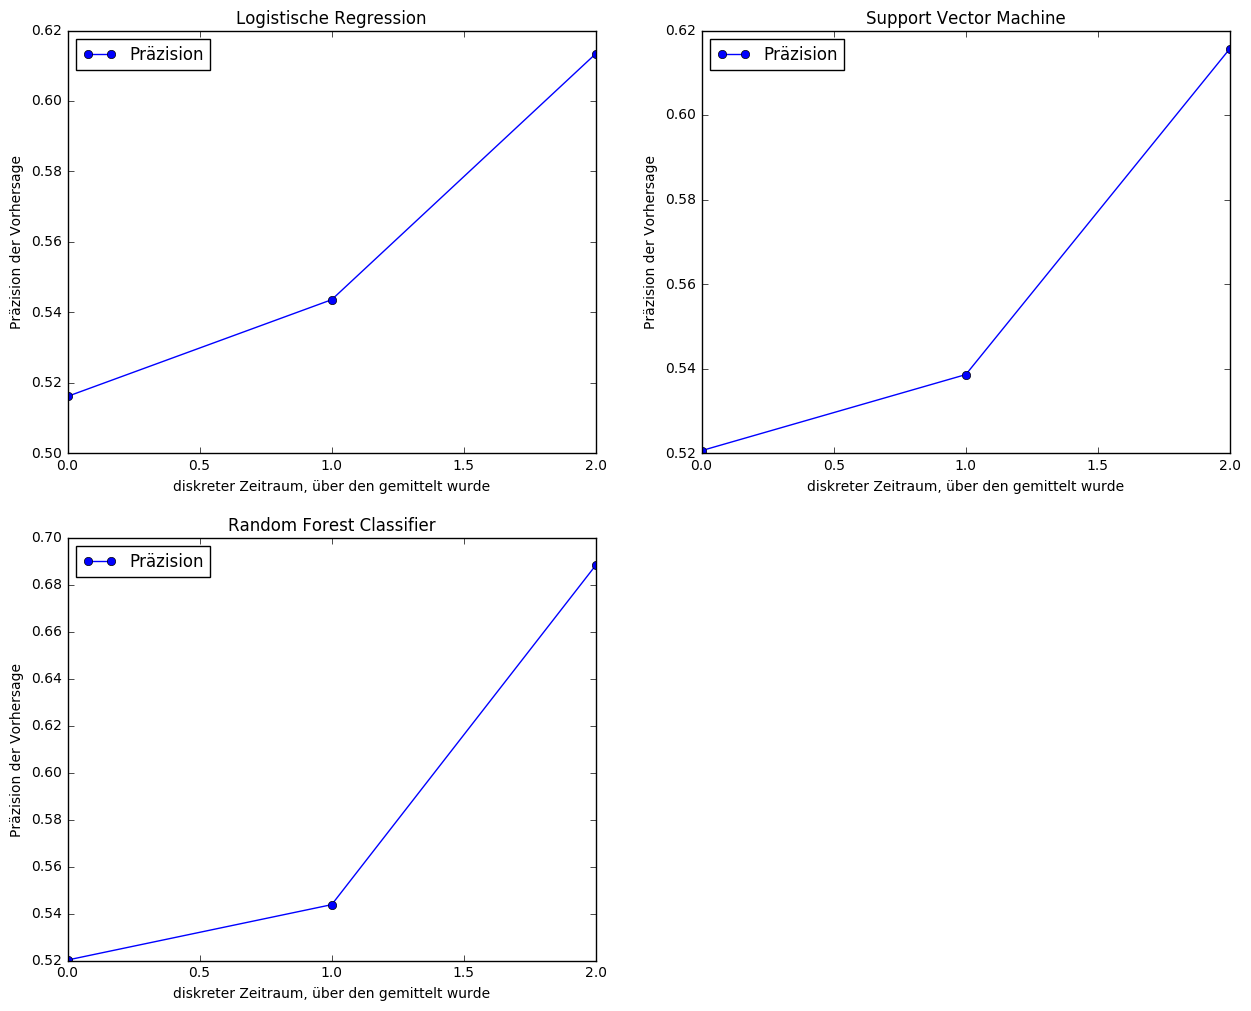

In [238]:
x1 = np.linspace(0, len(times)-1, len(times))

y11 = [sum(result_dict_lr['week'])/len(result_dict_lr['week']), 
       sum(result_dict_lr['month'])/len(result_dict_lr['month']), 
       sum(result_dict_lr['hyear'])/len(result_dict_lr['hyear'])]

y21 = [sum(result_dict_svm['week'])/len(result_dict_svm['week']), 
       sum(result_dict_svm['month'])/len(result_dict_svm['month']), 
       sum(result_dict_svm['hyear'])/len(result_dict_svm['hyear'])]

y31 = [sum(result_dict_rf['week'])/len(result_dict_rf['week']), 
       sum(result_dict_rf['month'])/len(result_dict_rf['month']), 
       sum(result_dict_rf['hyear'])/len(result_dict_rf['hyear'])]


plt.figure(figsize=(15,12))

plt.subplot(2, 2, 1)
plt.title('Logistische Regression')
l11,=plt.plot(x1, y11,  marker='o')
plt.legend([l11],["Präzision"],loc='upper left')
plt.xlabel('diskreter Zeitraum, über den gemittelt wurde')
plt.ylabel('Präzision der Vorhersage')

plt.subplot(2, 2, 2)
plt.title('Support Vector Machine')
l21,=plt.plot(x1, y21,  marker='o')
plt.legend([l21],["Präzision"],loc='upper left')
plt.xlabel('diskreter Zeitraum, über den gemittelt wurde')
plt.ylabel('Präzision der Vorhersage')

plt.subplot(2, 2, 3)
plt.title('Random Forest Classifier')
l31,=plt.plot(x1, y31,  marker='o')
plt.legend([l31],["Präzision"],loc='upper left')
plt.xlabel('diskreter Zeitraum, über den gemittelt wurde')
plt.ylabel('Präzision der Vorhersage')


plt.show()

LR: 0.6134471620959018
SVM: 0.6157405462871791
RF: 0.6883820959323766


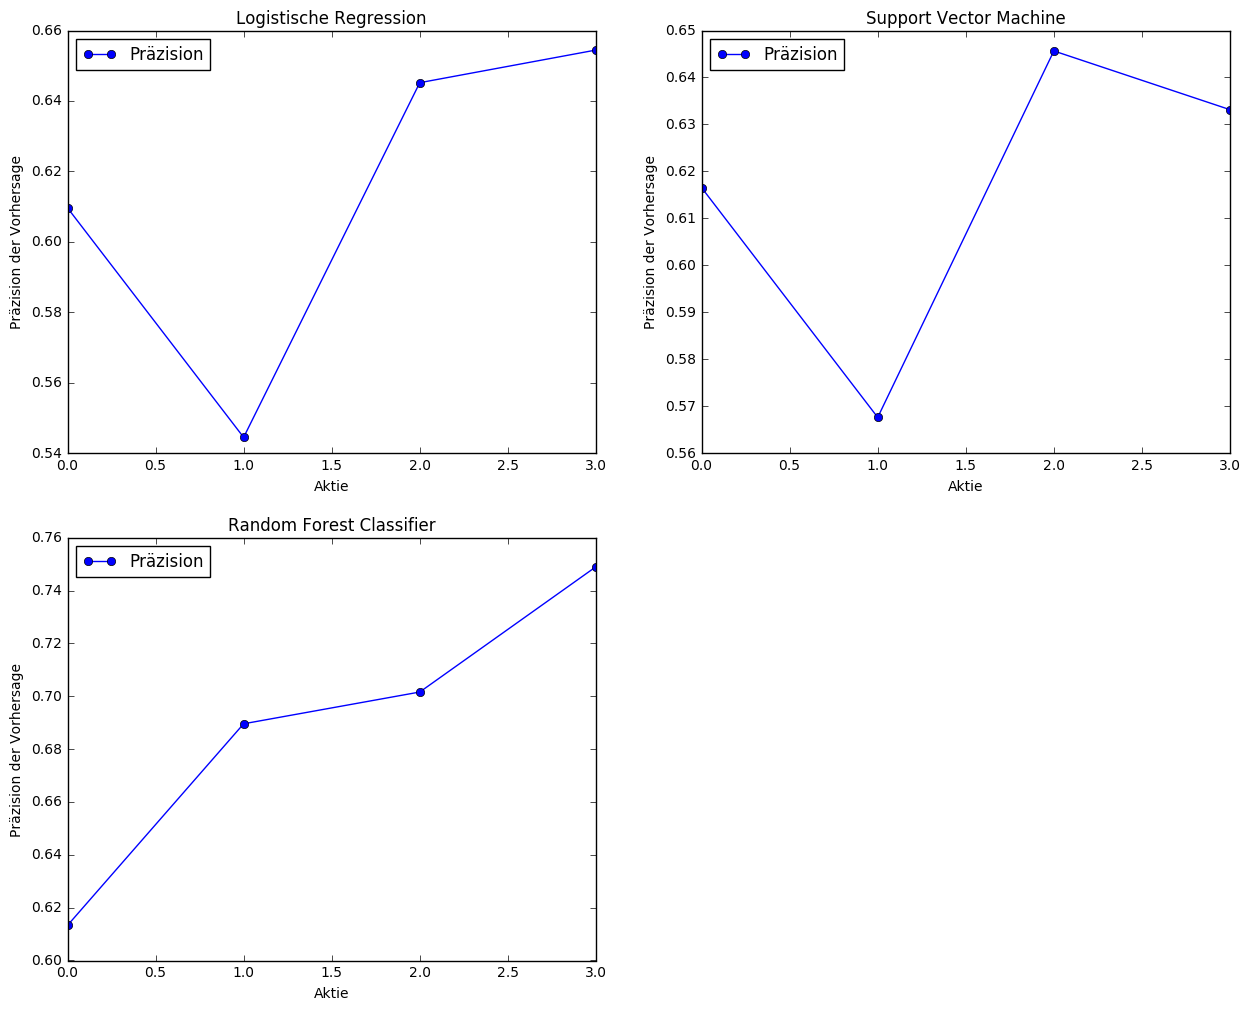

In [271]:
x1 = np.linspace(0, len(result_dict_lr['hyear'])-1, len(result_dict_lr['hyear']))

y11 = result_dict_lr['hyear']

y21 = result_dict_svm['hyear']

y31 = result_dict_rf['hyear']
plt.figure(figsize=(15,12))

plt.subplot(2, 2, 1)
plt.title('Logistische Regression')
l11,=plt.plot(x1, y11,  marker='o')
plt.legend([l11],["Präzision"],loc='upper left')
plt.xlabel('Aktie')
plt.ylabel('Präzision der Vorhersage')

plt.subplot(2, 2, 2)
plt.title('Support Vector Machine')
l21,=plt.plot(x1, y21,  marker='o')
plt.legend([l21],["Präzision"],loc='upper left')
plt.xlabel('Aktie')
plt.ylabel('Präzision der Vorhersage')

plt.subplot(2, 2, 3)
plt.title('Random Forest Classifier')
l31,=plt.plot(x1, y31,  marker='o')
plt.legend([l31],["Präzision"],loc='upper left')
plt.xlabel('Aktie')
plt.ylabel('Präzision der Vorhersage')

print('LR:', sum(y11)/len(y11))
print('SVM:', sum(y21)/len(y21))
print('RF:', sum(y31)/len(y31))
plt.show()

Der Random Forest Klassifikator erreicht bei der Apple-Aktie und einer Aggregation über ein halbes Jahr eine Präzision von um die 74%. Dieser Fall wird im Folgenden genauer untersucht

0.7473404255319149


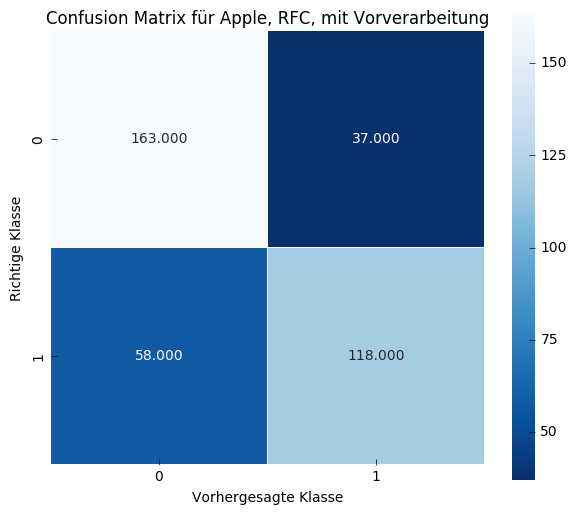

In [258]:
%matplotlib inline
X = stocks_training_data_dict['AAPL']['hyear'].loc[:,['Diff', 'Volume', 'avgOpen_hyear']]
Y = stocks_training_data_dict['AAPL']['hyear'].loc[:,['Win_open_hyear']]

X=X.astype('float')
Y=Y.astype('int')

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=.25)

pipe_rf.fit(x_train, np.ravel(y_train))

predictionsRF=pipe_rf.predict(x_test)

print(pipe_rf.score(x_test, y_test))

cmRF=metrics.confusion_matrix(y_test, predictionsRF)

plt.figure(figsize=(7,6))
plt.title('Confusion Matrix für Apple, RFC, mit Vorverarbeitung')
sns.heatmap(cmRF, annot=True, fmt=".3f", linewidths=.5, square=True, cmap='Blues_r')
plt.ylabel('Richtige Klasse')
plt.xlabel('Vorhergesagte Klasse')

## Classification Report

In [259]:
print(classification_report(y_test, predictionsRF))

             precision    recall  f1-score   support

          0       0.74      0.81      0.77       200
          1       0.76      0.67      0.71       176

avg / total       0.75      0.75      0.75       376



In [214]:
feature_importances = pd.DataFrame(pipe_rf.named_steps['clf'].feature_importances_,
                                   index = x_train.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)
print(feature_importances)

               importance
Diff             0.357115
avgOpen_hyear    0.341588
Volume           0.301297


# Das ganze nochmal mit den Rohdaten 

In [91]:
stocks_unprepared={}
for k in tickersymbols:
    df=pd.read_csv( k +'.csv')
    #print(k, df_unprepared.head())
    df.set_index('Date')
    stocks_unprepared[k]=df
    print(k)
    print(stocks_unprepared[k].head(2))

AAPL
         Date    Open    High     Low   Close    Volume
0  2018-03-01  178.54  179.78  172.66  175.00  48801970
1  2018-02-28  179.26  180.62  178.05  178.12  37782138
MSFT
         Date   Open   High    Low  Close    Volume
0  2018-03-01  93.99  94.57  91.84  92.85  37135561
1  2018-02-28  94.84  95.70  93.63  93.77  31167338
AMZN
         Date     Open     High     Low    Close   Volume
0  2018-03-01  1513.60  1518.49  1465.0  1493.45  6835230
1  2018-02-28  1519.51  1528.70  1512.0  1512.45  4515023
GOOGL
         Date     Open     High      Low    Close   Volume
0  2018-03-01  1109.54  1111.27  1067.28  1071.41  2766856
1  2018-02-28  1122.00  1127.65  1103.00  1103.92  2464619


# Sortierung des Dataframes umdrehen

In [92]:
for k in stocks_unprepared.keys():
    stocks_unprepared[k] = stocks_unprepared[k].iloc[::-1]
    stocks_unprepared[k].reset_index(inplace=True, drop=True)

# Hinzufügen einer Zielvariablen

In [93]:
# Nachdem die Reihenfolge invertiert wurde: alte Daten oben, neuere nach unten hin
# Differenz: df.iloc[1]-df.iloc[0]
for k in stocks_unprepared.keys():
    stocks_unprepared[k].loc[:,'Opendiff']=stocks_unprepared[k].loc[:, 'Open'].diff(periods=1)
    stocks_unprepared[k].loc[:,'Closediff']=stocks_unprepared[k].loc[:, 'Close'].diff(periods=1)

C:\Users\Sorel\Anaconda3\lib\site-packages\pandas\core\indexing.py:357: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\Sorel\Anaconda3\lib\site-packages\pandas\core\indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [94]:
for k in stocks_unprepared.keys():
    stocks_unprepared[k].loc[:,'Win_Open']=stocks_unprepared[k]['Opendiff'].apply(lambda x: 1 if (x>0) else 0)

C:\Users\Sorel\Anaconda3\lib\site-packages\pandas\core\indexing.py:357: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\Sorel\Anaconda3\lib\site-packages\pandas\core\indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [95]:
for k in stocks_unprepared.keys():
    stocks_unprepared[k].dropna(axis=0, inplace=True)
    print(stocks_unprepared[k].head())

         Date   Open   High    Low  Close    Volume  Opendiff  Closediff  \
1  2002-04-12  27.58  28.13  27.43  27.96  51226200     -0.36       0.56   
2  2002-04-15  28.00  28.38  27.70  27.84  46014000      0.42      -0.12   
3  2002-04-16  28.20  29.59  28.18  28.90  49688000      0.20       1.06   
4  2002-04-17  28.98  29.14  28.21  28.32  53319400      0.78      -0.58   
5  2002-04-18  28.40  28.75  26.34  28.18  53766600     -0.58      -0.14   

   Win_Open  
1         0  
2         1  
3         1  
4         1  
5         0  
         Date   Open   High    Low  Close    Volume  Opendiff  Closediff  \
1  2004-08-20  50.79  54.59  50.30  54.21  11429498      0.73       3.99   
2  2004-08-23  55.44  56.80  54.58  54.75   9140244      4.65       0.54   
3  2004-08-24  55.68  55.86  51.84  52.49   7632224      0.24      -2.26   
4  2004-08-25  52.53  54.05  51.99  53.05   4599110     -3.15       0.56   
5  2004-08-26  52.53  54.03  52.38  54.01   3551168      0.00       0.96   

  

C:\Users\Sorel\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


# Verschieben der Zielvariablen

In [97]:
for k in stocks_unprepared.keys():
    stocks_unprepared[k].loc[:, ['Win_Open']]=stocks_unprepared[k].loc[:, ['Win_Open', 'Win_Close']].shift(-1)

C:\Users\Sorel\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  from ipykernel import kernelapp as app
C:\Users\Sorel\Anaconda3\lib\site-packages\pandas\core\indexing.py:1367: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
C:\Users\Sorel\Anaconda3\lib\site-packages\pandas\core\indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

In [123]:
for k in stocks_unprepared.keys():
    stocks_unprepared[k].dropna(axis=0, inplace=True)

C:\Users\Sorel\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


# Lineare Regression 

In [149]:
results_lr_up = []
for k in stocks_unprepared.keys():
    print(k)
    stocks_unprepared[k] = stocks_unprepared[k].sample(frac=1)#shuffle df
    X = stocks_unprepared[k].loc[:,].values[:, 1:6]#Open, High, Low, Close, Volume
    Y = stocks_unprepared[k].loc[:,].values[:, 8:9]#Win_open
    X=X.astype('float')
    Y=Y.astype('int')

    seed = 7
    kfold = KFold(n_splits=n_folds, random_state=seed)
    results = cross_val_score(pipe_lr, X, np.ravel(Y), cv=kfold)
    print(results)
    print(results.mean())
    results_lr_up.append(results.mean())
print((np.max(results_lr_up)-np.min(results_lr_up))*100)

MSFT
[0.785      0.825      0.815      0.8375     0.835      0.835
 0.79       0.8275     0.80701754 0.81453634]
0.8171553884711779
GOOGL
[0.61290323 0.63636364 0.63929619 0.63049853 0.61764706 0.66470588
 0.61764706 0.67058824 0.62352941 0.63529412]
0.6348473348283594
AMZN
[0.625      0.65       0.5675     0.64       0.685      0.5475
 0.6825     0.6425     0.61152882 0.56892231]
0.6220451127819548
AAPL
[0.5875     0.5525     0.5325     0.525      0.5225     0.555
 0.515      0.5275     0.53634085 0.56641604]
0.5420256892230577
27.512969924812015


# SVM

In [148]:
results_svm_up = []
for k in stocks_unprepared.keys():
    print(k)
    stocks_unprepared[k] = stocks_unprepared[k].sample(frac=1)#shuffle df
    X = stocks_unprepared[k].loc[:,].values[:, 1:6]#Open, High, Low, Close, Volume
    Y = stocks_unprepared[k].loc[:,].values[:, 8:9]#Win_open
    X=X.astype('float')
    Y=Y.astype('int')

    seed = 7
    kfold = KFold(n_splits=n_folds, random_state=seed)
    results = cross_val_score(pipe_svm, X, np.ravel(Y), cv=kfold)
    print(results)
    print(results.mean())
    results_svm_up.append(results.mean())
print((np.max(results_svm_up)-np.min(results_svm_up))*100)

MSFT
[0.4725     0.5075     0.5025     0.49       0.505      0.5075
 0.52       0.495      0.55889724 0.55137845]
0.5110275689223058
GOOGL
[0.50146628 0.51906158 0.52785924 0.5542522  0.53235294 0.51470588
 0.51764706 0.55       0.51470588 0.52352941]
0.5255580472658271
AMZN
[0.51       0.51       0.4825     0.5275     0.5025     0.5425
 0.5425     0.56       0.54385965 0.54385965]
0.5265219298245615
AAPL
[0.4625     0.595      0.585      0.5425     0.525      0.5275
 0.5275     0.5125     0.46365915 0.52631579]
0.5267474937343358
1.5719924812029995


# Random Forest

In [147]:
results_rf_up = []
for k in stocks_unprepared.keys():
    print(k)
    stocks_unprepared[k] = stocks_unprepared[k].sample(frac=1)#shuffle df
    X = stocks_unprepared[k].loc[:,].values[:, 1:6]#Open, High, Low, Close, Volume
    Y = stocks_unprepared[k].loc[:,].values[:, 8:9]#Win_open
    X=X.astype('float')
    Y=Y.astype('int')

    seed = 7
    kfold = KFold(n_splits=n_folds, random_state=seed)
    results = cross_val_score(pipe_rf, X, np.ravel(Y), cv=kfold)
    print(results)
    print(results.mean())
    results_rf_up.append(results.mean())
print((np.max(results_rf_up)-np.min(results_rf_up))*100)

MSFT
[0.685      0.715      0.72       0.7075     0.68       0.7025
 0.6825     0.69       0.72431078 0.69423559]
0.7001046365914786
GOOGL
[0.64222874 0.62756598 0.60997067 0.68621701 0.64411765 0.56764706
 0.64117647 0.68823529 0.64117647 0.61764706]
0.6365982404692083
AMZN
[0.6675     0.6575     0.65       0.63       0.6525     0.7025
 0.7        0.69       0.67669173 0.62406015]
0.6650751879699248
AAPL
[0.6075     0.6575     0.6475     0.6175     0.67       0.595
 0.6275     0.6575     0.64411028 0.64160401]
0.6365714285714286
6.353320802005003


LR: 0.6540183813261375
SVM: 0.5224637599367576
RF: 0.6595873734005101


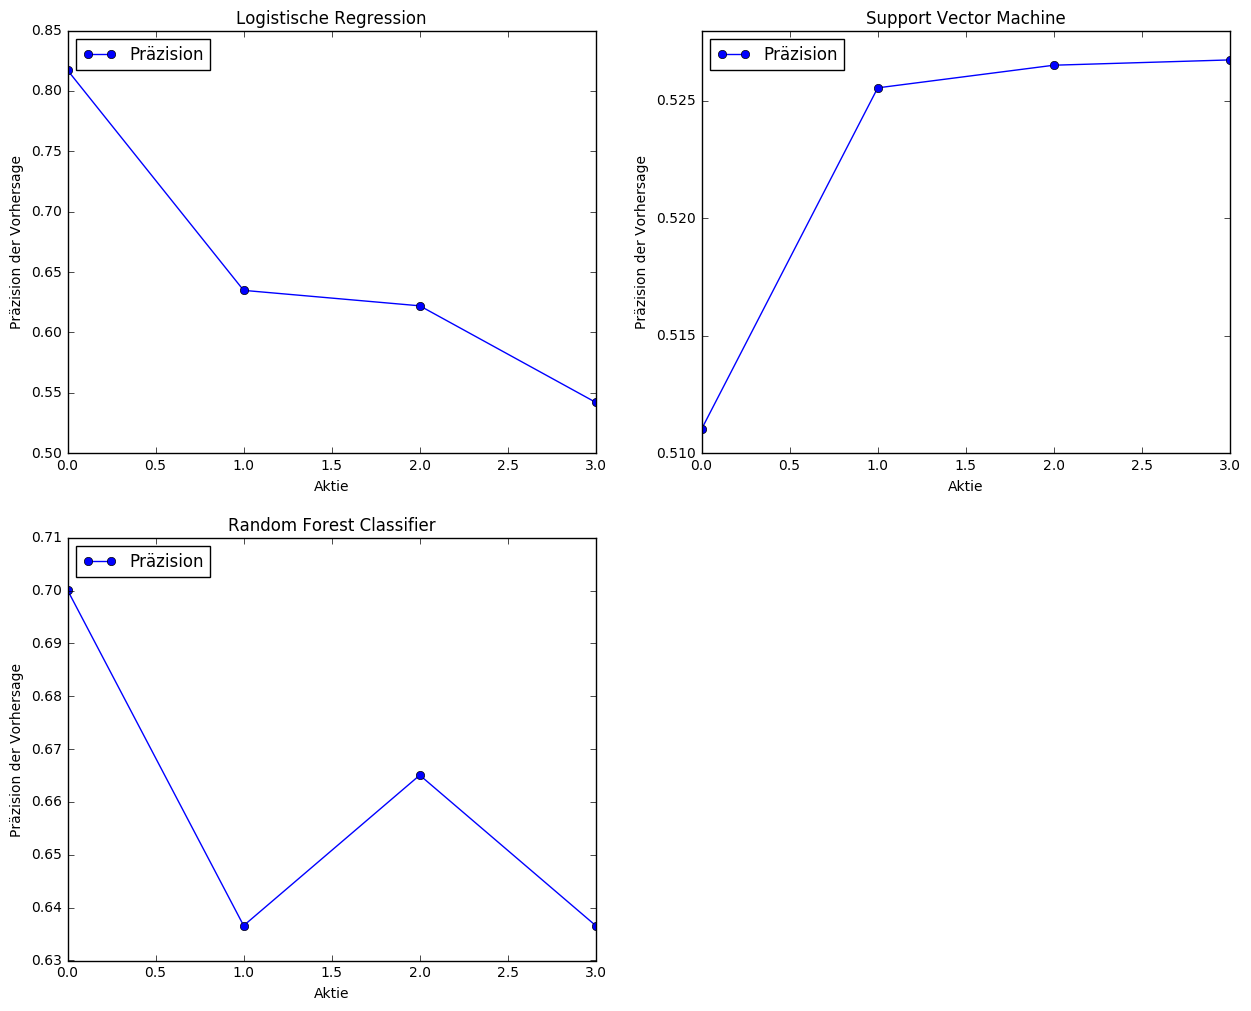

In [268]:
x1 = np.linspace(0, len(results_lr_up)-1, len(results_lr_up))

y11 = results_lr_up

y21 = results_svm_up

y31 = results_rf_up
plt.figure(figsize=(15,12))

plt.subplot(2, 2, 1)
plt.title('Logistische Regression')
l11,=plt.plot(x1, y11,  marker='o')
plt.legend([l11],["Präzision"],loc='upper left')
plt.xlabel('Aktie')
plt.ylabel('Präzision der Vorhersage')

plt.subplot(2, 2, 2)
plt.title('Support Vector Machine')
l21,=plt.plot(x1, y21,  marker='o')
plt.legend([l21],["Präzision"],loc='upper left')
plt.xlabel('Aktie')
plt.ylabel('Präzision der Vorhersage')

plt.subplot(2, 2, 3)
plt.title('Random Forest Classifier')
l31,=plt.plot(x1, y31,  marker='o')
plt.legend([l31],["Präzision"],loc='upper left')
plt.xlabel('Aktie')
plt.ylabel('Präzision der Vorhersage')

print('LR:', sum(results_lr_up)/len(results_lr_up))
print('SVM:', sum(results_svm_up)/len(results_svm_up))
print('RF:', sum(results_rf_up)/len(results_rf_up))
plt.show()

Die Lineare Regression hat erstaunlicherweise eine Präzision von über 80% für die Microsoft-Aktie hinbekommen. Dieser Fall wird im Folgenden genauer betrachtet.

0.804


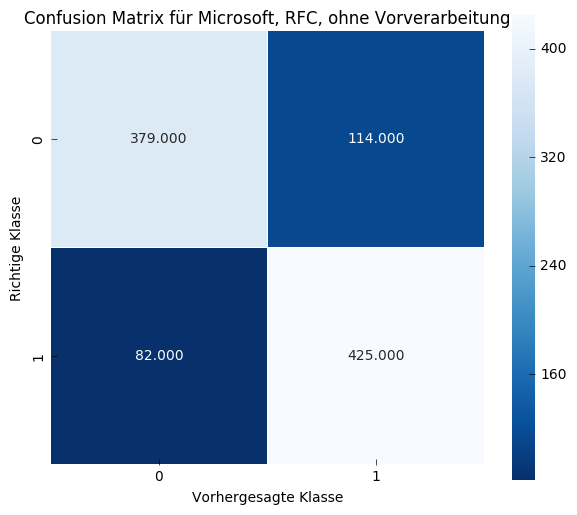

In [260]:
%matplotlib inline
X = stocks_unprepared['MSFT'].loc[:,['Open', 'High', 'Low', 'Close', 'Volume']]#Open, High, Low, Close, Volume
Y = stocks_unprepared['MSFT'].loc[:,['Win_Open']]#Win_open

X=X.astype('float')
Y=Y.astype('int')

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=.25)

pipe_lr.fit(x_train, np.ravel(y_train))

predictionsLR=pipe_lr.predict(x_test)

print(pipe_lr.score(x_test, y_test))

cmLR=metrics.confusion_matrix(y_test, predictionsLR)

plt.figure(figsize=(7,6))
plt.title('Confusion Matrix für Microsoft, RFC, ohne Vorverarbeitung')
sns.heatmap(cmLR, annot=True, fmt=".3f", linewidths=.5, square=True, cmap='Blues_r')
plt.ylabel('Richtige Klasse')
plt.xlabel('Vorhergesagte Klasse')

## Classification Report

In [261]:
print(classification_report(y_test, predictionsLR))

             precision    recall  f1-score   support

          0       0.82      0.77      0.79       493
          1       0.79      0.84      0.81       507

avg / total       0.81      0.80      0.80      1000

